# Music Genre Clustering Using Tabular Features

### Introduction

This notebook explores clustering songs using K-Means based on tabular features extracted from audio files.  
The goal is to see if songs from the same genre tend to cluster together based on their audio tabular features.

### Goal

Show how tabular audio features can be used for unsupervised learning on music data.


### Setup

Imports for the code:




In [ ]:
import librosa
from IPython.display import Audio
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

I used Google Colab for this notebook so I load the songs data directly from my Google Drive. (all songs are available on GitHub folder - Data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/data_songs.zip /content/piano_relax.zip
!cp /content/drive/MyDrive/data_songs.zip /content/rock_songs.zip
!cp /content/drive/MyDrive/data_songs.zip /content/jazz_songs.zip
!cp /content/drive/MyDrive/data_songs.zip /content/techno_music.zip

In [ ]:
!unzip /content/piano_relax.zip -d /content/piano_relax/
!unzip /content/rock_songs.zip -d /content/rock_songs/
!unzip /content/jazz_songs.zip -d /content/jazz_songs/
!unzip /content/techno_music.zip -d /content/techno_music/

Archive:  /content/piano_relax.zip
   creating: /content/piano_relax/jazz_songs/
  inflating: /content/piano_relax/jazz_songs/jazz_1.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_10.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_11.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_12.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_13.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_14.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_15.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_16.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_17.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_18.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_19.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_2.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_20.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_21.mp3  
  inflating: /content/piano_relax/jazz_songs/jazz_22.mp3  
  inflating: /content/piano_relax/ja

function to extract audio tabular features from folder with mp3/wav songs

In [ ]:
def extract_audio_features(folder_path):
    # Initialize an empty list to store data for each file
    data_list = []

    # Loop through all files in the given folder
    for filename in os.listdir(folder_path):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)

        # Load the audio file
        y, sr = librosa.load(file_path, sr=44100)

        # Calculate the tempo and beat frames
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_count = len(beat_frames)

        # Harmonic and percussive separation
        S = librosa.stft(y)
        H, P = librosa.decompose.hpss(S)
        y_harmonic = librosa.istft(H)
        y_percussive = librosa.istft(P)

        harmonic_mean = np.mean(np.abs(y_harmonic))
        harmonic_median = np.median(np.abs(y_harmonic))
        harmonic_min = np.min(y_harmonic)
        harmonic_max = np.max(y_harmonic)

        percussive_mean = np.mean(np.abs(y_percussive))
        percussive_median = np.median(np.abs(y_percussive))
        percussive_min = np.min(y_percussive)
        percussive_max = np.max(y_percussive)

        # RMS (Root Mean Square)
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)
        rms_std = np.std(rms)
        rms_max = np.max(rms)

        # Dynamic Range (in decibels)
        epsilon = 1e-6  # small value to avoid log(0)
        db = 20 * np.log10(np.abs(y) + epsilon)
        dynamic_range = np.max(db) - np.min(db)

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)

        # Chroma feature
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma)
        chroma_std = np.std(chroma)

        # MFCC (Mel-Frequency Cepstral Coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc)
        mfcc_std = np.std(mfcc)

        # Spectral centroid
        centroid_full = librosa.feature.spectral_centroid(y=y, sr=sr)
        frame_times = librosa.frames_to_time(np.arange(centroid_full.shape[1]), sr=sr)
        centroid = centroid_full[0][frame_times > 1.5]
        centroid_mean = np.mean(centroid)
        centroid_std = np.std(centroid)
        centroid_max = np.max(centroid)

        # Spectral bandwidth
        bandwidth_full = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        bandwidth = bandwidth_full[0][frame_times > 1.5]
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_std = np.std(bandwidth)
        bandwidth_max = np.max(bandwidth)

        # Spectral rolloff
        rolloff_full = librosa.feature.spectral_rolloff(y=y, sr=sr)
        rolloff = rolloff_full[0][frame_times > 1.5]
        rolloff_mean = np.mean(rolloff)
        rolloff_std = np.std(rolloff)
        rolloff_max = np.max(rolloff)

        # Spectral contrast
        contrast_full = librosa.feature.spectral_contrast(y=y, sr=sr)
        contrast = contrast_full[0][frame_times > 1.5]
        contrast_mean = np.mean(contrast)
        contrast_std = np.std(contrast)
        contrast_max = np.max(contrast)

        # Spectral flatness
        flatness_full = librosa.feature.spectral_flatness(y=y)
        flatness = flatness_full[0][frame_times > 1.5]
        flatness_mean = np.mean(flatness)
        flatness_std = np.std(flatness)
        flatness_max = np.max(flatness)

        # Onset strength
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        onset_strength_mean = np.mean(onset_env)
        onset_strength_std = np.std(onset_env)
        onset_strength_max = np.max(onset_env)

        # Calculate the STFT and frequency bins
        spec = np.abs(librosa.stft(y, n_fft=2048))
        freq_bins = librosa.fft_frequencies(sr=sr, n_fft=2048)

        # Define frequency bands
        low_freq_idx = np.where(freq_bins < 500)[0]
        mid_freq_idx = np.where((freq_bins >= 500) & (freq_bins < 2000))[0]
        high_freq_idx = np.where(freq_bins >= 2000)[0]

        # Sum energy across bands
        low_energy = np.sum(spec[low_freq_idx, :], axis=0)
        mid_energy = np.sum(spec[mid_freq_idx, :], axis=0)
        high_energy = np.sum(spec[high_freq_idx, :], axis=0)

        # Total energy
        total_energy = low_energy + mid_energy + high_energy

        # Calculate the energy ratios
        valid = total_energy > 0
        # Set invalid frames to zero or skip them
        low_ratio = np.zeros_like(total_energy)
        mid_ratio = np.zeros_like(total_energy)
        high_ratio = np.zeros_like(total_energy)

        low_ratio[valid] = low_energy[valid] / total_energy[valid]
        mid_ratio[valid] = mid_energy[valid] / total_energy[valid]
        high_ratio[valid] = high_energy[valid] / total_energy[valid]

        # Summary features
        low_energy_ratio = np.mean(low_ratio)
        mid_energy_ratio = np.mean(mid_ratio)
        high_energy_ratio = np.mean(high_ratio)

        # Collect the features into a dictionary
        data = {
            'file_name': filename,
            'tempo': tempo[0],
            'beat_count': beat_count,
            'harmonic_average': harmonic_mean,
            'harmonic_median': harmonic_median,
            'harmonic_min': harmonic_min,
            'harmonic_max': harmonic_max,
            'percussive_average': percussive_mean,
            'percussive_median': percussive_median,
            'percussive_min': percussive_min,
            'percussive_max': percussive_max,
            'rms_average': rms_mean,
            'rms_std': rms_std,
            'rms_max': rms_max,
            'dynamic_range': dynamic_range,
            'zero_crossing_rate_average': zcr_mean,
            'zero_crossing_rate_std': zcr_std,
            'chroma_average': chroma_mean,
            'chroma_std': chroma_std,
            'MFCC_average': mfcc_mean,
            'MFCC_std': mfcc_std,
            'spectral_centroid_average': centroid_mean,
            'spectral_centroid_std': centroid_std,
            'spectral_centroid_max': centroid_max,
            'spectral_bandwidth_average': bandwidth_mean,
            'spectral_bandwidth_std': bandwidth_std,
            'spectral_bandwidth_max': bandwidth_max,
            'spectral_rolloff_average': rolloff_mean,
            'spectral_rolloff_std': rolloff_std,
            'spectral_rolloff_max': rolloff_max,
            'spectral_contrast_average': contrast_mean,
            'spectral_contrast_std': contrast_std,
            'spectral_contrast_max': contrast_max,
            'spectral_flatness_average': flatness_mean,
            'spectral_flatness_std': flatness_std,
            'spectral_flatness_max': flatness_max,
            'onset_strength_average': onset_strength_mean,
            'onset_strength_std': onset_strength_std,
            'onset_strength_max': onset_strength_max,
            'low_energy_ratio': low_energy_ratio,
            'mid_energy_ratio': mid_energy_ratio,
            'high_energy_ratio': high_energy_ratio
        }
        data_list.append(data)
        print(f'{filename} sample done')

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data_list)

    return df

In [ ]:
genres = {
    'piano': '/content/piano_relax/piano_relax/',
    'jazz': '/content/jazz_songs/jazz_songs/',
    'rock': '/content/rock_songs/rock_songs/',
    'techno': '/content/techno_music/techno_music/'
}

# Process all artists with error handling
genres_dfs = {}
for genre, path in genres.items():
    try:
        genres_dfs[genre] = extract_audio_features(path)
        genres_dfs[genre]['genre'] = genre
    except Exception as e:
        print(f"Error processing {genre}: {str(e)}")

classical_music_4.mp3 sample done
classical_music_5.mp3 sample done
classical_music_22.mp3 sample done
classical_music_16.mp3 sample done
classical_music_25.mp3 sample done
classical_music_24.mp3 sample done
classical_music_3.mp3 sample done
classical_music_12.mp3 sample done
classical_music_17.mp3 sample done
classical_music_9.mp3 sample done
classical_music_13.mp3 sample done
classical_music_7.mp3 sample done
classical_music_14.mp3 sample done
classical_music_10.mp3 sample done
classical_music_19.mp3 sample done
classical_music_11.mp3 sample done
classical_music_6.mp3 sample done
classical_music_8.mp3 sample done
classical_music_15.mp3 sample done
classical_music_21.mp3 sample done
classical_music_2.mp3 sample done
classical_music_23.mp3 sample done
classical_music_20.mp3 sample done
jazz_18.mp3 sample done
jazz_17.mp3 sample done
jazz_20.mp3 sample done
jazz_4.mp3 sample done
jazz_19.mp3 sample done
jazz_25.mp3 sample done
jazz_7.mp3 sample done
jazz_24.mp3 sample done
jazz_14.mp3 s

In [ ]:
df = pd.concat(genres_dfs.values(), ignore_index=True)

Let's see our tabular dataframe:

In [ ]:
df.head()

,file_name,tempo,beat_count,harmonic_average,harmonic_median,harmonic_min,harmonic_max,percussive_average,percussive_median,percussive_min,...,onset_strength_average,onset_strength_std,onset_strength_max,low_energy_ratio,mid_energy_ratio,high_energy_ratio,genre,cluster,pca_1,pca_2
0,classical_music_4.mp3,215.332031,354,0.052184,0.033099,-0.460859,0.536375,0.007347,0.003460,-0.195274,...,0.524628,0.472967,6.077675,0.756069,0.215036,0.021636,piano,1,6.179577,4.728085
1,classical_music_5.mp3,172.265625,294,0.047723,0.031685,-0.625153,0.547986,0.006648,0.002383,-0.173450,...,0.524813,0.713863,11.220869,0.675653,0.297625,0.026722,piano,1,7.532151,0.791348
2,classical_music_22.mp3,117.453835,80,0.050315,0.036420,-0.413316,0.409988,0.004864,0.002414,-0.282144,...,0.362566,0.596851,13.520690,0.843654,0.138828,0.014380,piano,1,7.510162,-0.273721
3,classical_music_16.mp3,112.347147,142,0.031690,0.023578,-0.232876,0.252174,0.005012,0.002861,-0.088755,...,0.604571,0.370471,4.524207,0.712942,0.251067,0.035991,piano,1,9.017417,-1.435699
4,classical_music_25.mp3,126.048018,217,0.054371,0.035973,-0.529242,0.534064,0.006324,0.003636,-0.131379,...,0.366666,0.549536,8.526440,0.762881,0.221624,0.015494,piano,1,7.695513,0.368851


### Simple classification with KMEANS

In [ ]:
# excluding file_name and genre
features = df.drop(['file_name', 'genre'], axis=1)
feature_names = features.columns
genres = df['genre']

In [ ]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

we wish to create 4 cluster (as we have 4 different genres)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

df['cluster'] = clusters

Let's analyze the results:

In [ ]:
cluster_genre_counts = pd.crosstab(df['cluster'], df['genre'])
print("Genre distribution in each cluster:")
print(cluster_genre_counts)

cluster_genre_percentages = pd.crosstab(df['cluster'], df['genre'], normalize='index') * 100
print("\nPercentage of genres in each cluster:")
print(cluster_genre_percentages.round(2))

Genre distribution in each cluster:
genre    jazz  piano  rock  techno
cluster                           
0          22      0     7       5
1           0     23     0       0
2           2      0     0      14
3           1      0    18       6

Percentage of genres in each cluster:
genre     jazz  piano   rock  techno
cluster                             
0        64.71    0.0  20.59   14.71
1         0.00  100.0   0.00    0.00
2        12.50    0.0   0.00   87.50
3         4.00    0.0  72.00   24.00


### Summery statistics for each cluster

In [ ]:
print("\nCluster Summary Statistics:")
for i in range(4):
    print(f"\nCluster {i}:")
    cluster_data = df[df['cluster'] == i]
    print(f"Total samples: {len(cluster_data)}")
    print(f"Genre distribution: {cluster_data['genre'].value_counts().to_dict()}")
    print(f"Dominant genre: {cluster_data['genre'].value_counts().idxmax()}")
    genre_percentage = (cluster_data['genre'].value_counts() / len(cluster_data) * 100).round(2)
    print(f"Genre percentages: {genre_percentage.to_dict()}")


Cluster Summary Statistics:

Cluster 0:
Total samples: 34
Genre distribution: {'jazz': 22, 'rock': 7, 'techno': 5}
Dominant genre: jazz
Genre percentages: {'jazz': 64.71, 'rock': 20.59, 'techno': 14.71}

Cluster 1:
Total samples: 23
Genre distribution: {'piano': 23}
Dominant genre: piano
Genre percentages: {'piano': 100.0}

Cluster 2:
Total samples: 16
Genre distribution: {'techno': 14, 'jazz': 2}
Dominant genre: techno
Genre percentages: {'techno': 87.5, 'jazz': 12.5}

Cluster 3:
Total samples: 25
Genre distribution: {'rock': 18, 'techno': 6, 'jazz': 1}
Dominant genre: rock
Genre percentages: {'rock': 72.0, 'techno': 24.0, 'jazz': 4.0}


<Figure size 1600x700 with 0 Axes>

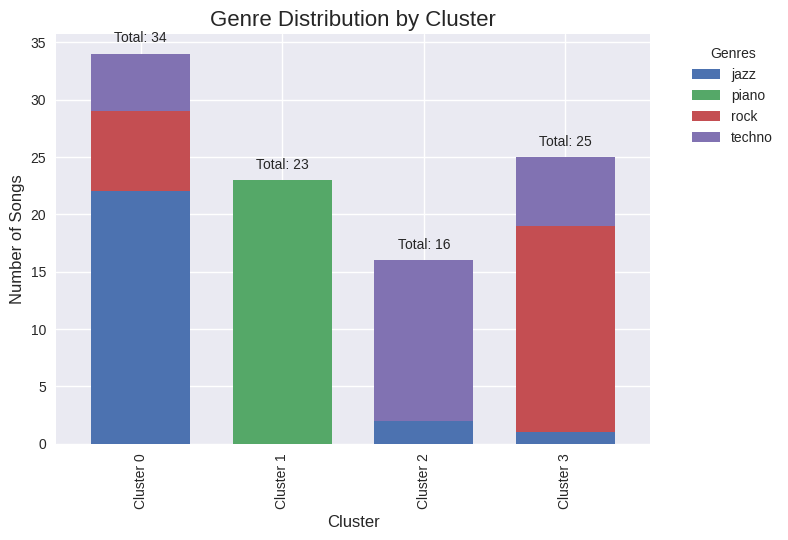

In [ ]:
plt.figure(figsize=(16, 7))
ax = cluster_genre_counts.plot(kind='bar', stacked=True, width=0.7)
plt.title('Genre Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(range(len(cluster_genre_counts.index)),
           [f'Cluster {i}' for i in range(len(cluster_genre_counts.index))])
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
for i, total in enumerate(cluster_genre_counts.sum(axis=1)):
    ax.text(i, total + 1, f'Total: {total}', ha='center')

plt.tight_layout()
plt.show()

### Feature importance analysis:

In [ ]:
cluster_centers = kmeans.cluster_centers_
feature_importance = pd.DataFrame(cluster_centers, columns=feature_names)

feature_importance_std = pd.DataFrame(
    scaler.transform(cluster_centers),
    columns=feature_names
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Print the top 5 most important features for each cluster
for i in range(4):
    print(f"\nCluster {i} - Top 5 characteristic features:")
    sorted_features = feature_importance_std.iloc[i].abs().sort_values(ascending=False)
    print(sorted_features.head(5))


Cluster 0 - Top 5 characteristic features:
spectral_flatness_average    167.737013
dynamic_range                 46.432226
percussive_median             39.783412
percussive_average            23.976010
spectral_flatness_std         16.930051
Name: 0, dtype: float64

Cluster 1 - Top 5 characteristic features:
percussive_median             71.772176
zero_crossing_rate_std        52.900636
percussive_average            47.952039
dynamic_range                 46.722062
zero_crossing_rate_average    44.681978
Name: 1, dtype: float64

Cluster 2 - Top 5 characteristic features:
percussive_median            82.021856
spectral_flatness_average    68.371789
chroma_std                   46.482050
dynamic_range                46.110323
percussive_average           43.107490
Name: 2, dtype: float64

Cluster 3 - Top 5 characteristic features:
spectral_flatness_average    551.414226
zero_crossing_rate_std        68.606018
spectral_flatness_std         52.085683
percussive_median             47.6721